In [348]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.fft import fft

In [349]:
import os

In [350]:
folder_path = 'UNSW IoT Dataset (New)\\CSV Files'
file_paths = [os.path.join(folder_path,file) for file in os.listdir(folder_path) if file.endswith('.csv')]

In [351]:
data = pd.concat([pd.read_csv(file) for file in file_paths], ignore_index = True)

In [352]:
data.head()
data = data.drop(data[data['eth.src'] == '14:cc:20:51:33:ea'].index)

In [353]:
data = data.reset_index(drop = True)
data

,Packet ID,TIME,Size,eth.src,eth.dst,IP.src,IP.dst,IP.proto,port.src,port.dst
0,1,1474552802,70,18:b7:9e:02:20:44,14:cc:20:51:33:ea,192.168.1.120,46.105.38.79,6,40234,5228
1,2,1474552802,66,18:b7:9e:02:20:44,14:cc:20:51:33:ea,192.168.1.120,46.105.38.79,6,40234,5228
2,4,1474552802,60,d0:52:a8:00:67:5e,14:cc:20:51:33:ea,192.168.1.196,52.1.40.122,6,3063,443
3,6,1474552802,88,70:ee:50:18:34:43,14:cc:20:51:33:ea,192.168.1.241,192.168.1.1,17,61725,53
4,11,1474552802,66,18:b7:9e:02:20:44,14:cc:20:51:33:ea,192.168.1.120,46.105.38.79,6,40234,5228
...,...,...,...,...,...,...,...,...,...,...
1297786,573839,1474898397,156,30:8c:fb:2f:e4:b2,14:cc:20:51:33:ea,192.168.1.106,52.87.241.159,6,40767,443
1297787,573842,1474898397,66,00:24:e4:11:18:a8,14:cc:20:51:33:ea,192.168.1.166,89.30.121.13,6,47747,1935
1297788,573844,1474898397,66,30:8c:fb:2f:e4:b2,14:cc:20:51:33:ea,192.168.1.106,52.87.241.159,6,40767,443
1297789,573845,1474898398,156,30:8c:fb:2f:e4:b2,14:cc:20:51:33:ea,192.168.1.106,52.87.241.159,6,40767,443


In [354]:
data1 = data[['Size','eth.src','IP.proto','port.src','port.dst']]

In [355]:
data1.shape

(1297791, 5)

In [356]:
def apply_fft(df,columns):
    fft_features = pd.DataFrame()
    for col in columns:
        fft_values = np.abs(fft(df[col].values))
        fft_features[col+'_fft'] = fft_values[:len(fft_values)]
    return fft_features

In [357]:
data1.head()

,Size,eth.src,IP.proto,port.src,port.dst
0,70,18:b7:9e:02:20:44,6,40234,5228
1,66,18:b7:9e:02:20:44,6,40234,5228
2,60,d0:52:a8:00:67:5e,6,3063,443
3,88,70:ee:50:18:34:43,17,61725,53
4,66,18:b7:9e:02:20:44,6,40234,5228


In [358]:
numeric_columns = ['Size']
non_numeric_columns = ['eth.src']
fft_data = apply_fft(data1,data1[numeric_columns])

In [359]:
feature_vector = ['Size','IP.proto','port.src','port.dst']

In [360]:
X = pd.concat([fft_data,data1[feature_vector]],axis = 1)
y = data1['eth.src']

In [361]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [362]:
classifiers = {
    "Decision Tree" : DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, min_samples_split = 10, random_state = 0),
    "Random Forest" : RandomForestClassifier(n_estimators = 150, max_depth = 15, criterion = 'entropy', random_state = 42)
}

In [363]:
# clf_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 22, min_samples_split = 4, random_state = None)
clf_dt = DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 22,
                                                         max_features = 20, max_leaf_nodes = None,
                                                         min_impurity_decrease = 0.0,
                                                         min_samples_leaf = 1, min_samples_split = 4,
                                                         min_weight_fraction_leaf = 0.0,
                                                         random_state = None, splitter = 'best')
# clf_rf = RandomForestClassifier(n_estimators = 75, criterion = 'entropy', min_samples_split = 10, random_state = None)
clf_rf = RandomForestClassifier(bootstrap = True, class_weight = None,
                                                         criterion = 'gini', min_impurity_decrease=0.0,
                                                         min_samples_leaf = 1, min_samples_split = 10,
                                                         min_weight_fraction_leaf = 0.0, n_estimators = 70,
                                                         n_jobs = None, oob_score = False, random_state = None,
                                                         verbose = 0, warm_start = False)

In [364]:
clf_dt.fit(X_train,y_train)
y_pred = clf_dt.predict(X_test)

In [365]:
accuracy = metrics.accuracy_score(y_test,y_pred)
precision = metrics.precision_score(y_test, y_pred, average = 'macro')
recall = metrics.recall_score(y_test, y_pred, average = 'macro')
f1_score = metrics.f1_score(y_test,y_pred,average='macro')

# printing the metrics (macro values for precision, recall and F1-Score)
print(f'Metrics for the Decision Tree Classifier: ')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1_Score: {f1_score:.4f}')

Metrics for the Decision Tree Classifier: 
Accuracy: 0.9866
Precision: 0.9498
Recall: 0.9359
F1_Score: 0.9422


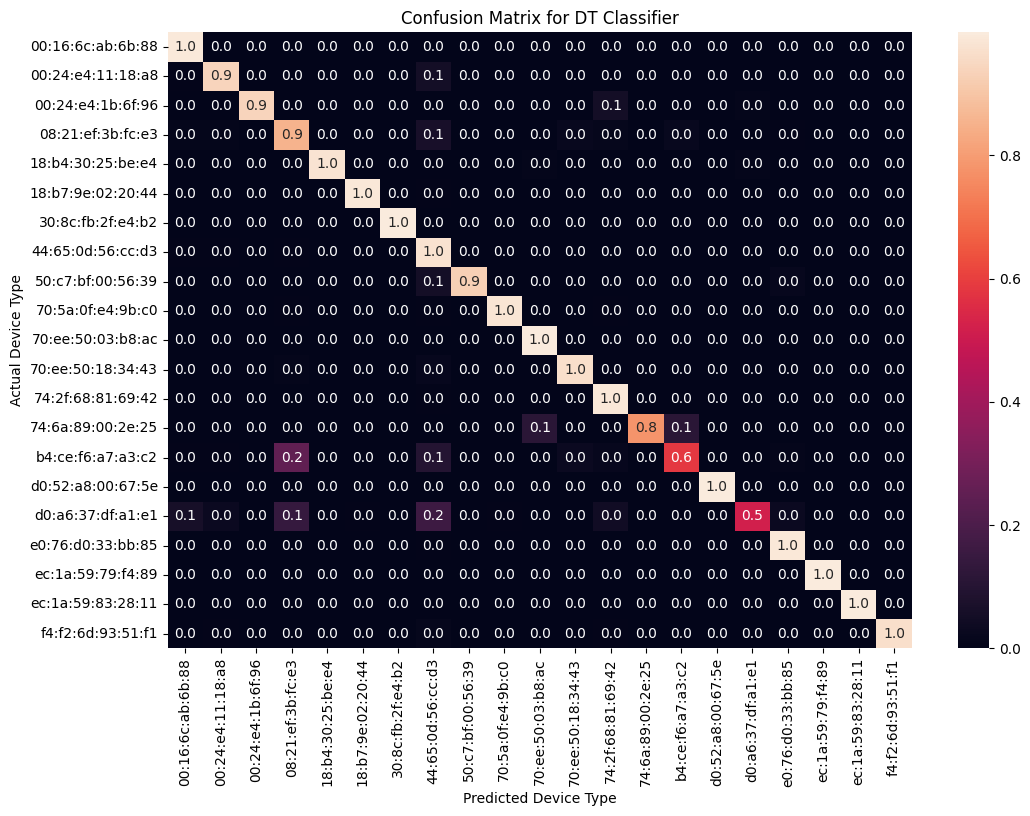

In [371]:
# creating a confusion matrix 
cnf_matrix_dt = metrics.confusion_matrix(y_test,y_pred)
normalized_cnf_matrix_dt = cnf_matrix_dt.astype('float')/cnf_matrix_dt.sum(axis = 1)[:,np.newaxis] 
plt.figure(figsize = (12,8))
sns.heatmap(normalized_cnf_matrix_dt,annot = True,fmt = '.1f',
           xticklabels = label_encoder.classes_,
           yticklabels = label_encoder.classes_)
plt.xlabel('Predicted Device Type')
plt.ylabel('Actual Device Type')
plt.title(f'Confusion Matrix for DT Classifier')
plt.show()

In [367]:
clf_rf.fit(X_train,y_train)
y_pred = clf_rf.predict(X_test)

In [368]:
accuracy = metrics.accuracy_score(y_test,y_pred)
precision = metrics.precision_score(y_test, y_pred, average = 'macro')
recall = metrics.recall_score(y_test, y_pred, average = 'macro')
f1_score = metrics.f1_score(y_test,y_pred,average='macro')

# printing the metrics (macro values for precision, recall and F1-Score)
print(f'Metrics for the Random Forest Classifier: ')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1_Score: {f1_score:.4f}')

Metrics for the Random Forest Classifier: 
Accuracy: 0.9838
Precision: 0.9617
Recall: 0.9222
F1_Score: 0.9384


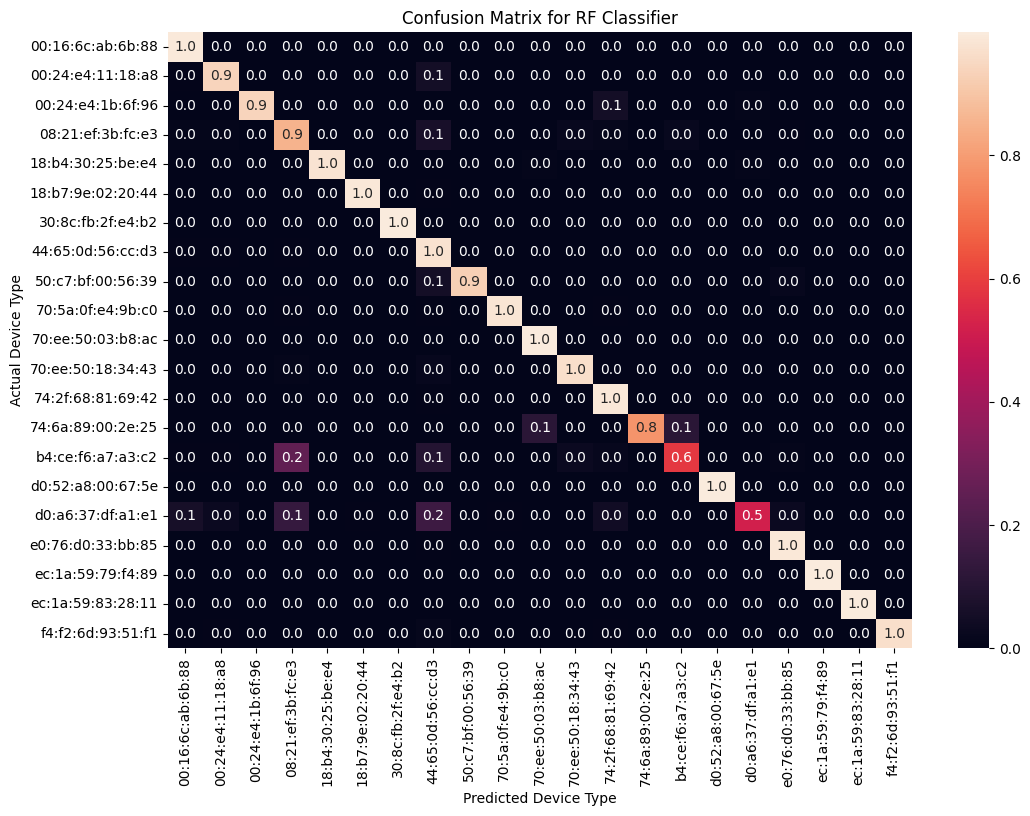

In [372]:
# creating a confusion matrix 
cnf_matrix_rf = metrics.confusion_matrix(y_test,y_pred)
normalized_cnf_matrix_rf = cnf_matrix_rf.astype('float')/cnf_matrix_dt.sum(axis = 1)[:,np.newaxis] 
plt.figure(figsize = (12,8))
sns.heatmap(normalized_cnf_matrix_rf,annot = True,fmt = '.1f',
           xticklabels = label_encoder.classes_,
           yticklabels = label_encoder.classes_)
plt.xlabel('Predicted Device Type')
plt.ylabel('Actual Device Type')
plt.title(f'Confusion Matrix for RF Classifier')
plt.show()